# Кластеризация данных
КБ-211 Коренев Денис

**Задание:** разбить заданный датасет на 5 кластеров и на 2 кластера, используя агломеративный иерархический метод и метод к-средних; сравнить результаты; данные выбрать из папки "данные" в соответствии с алфавитом названий файлов и с номером по списку в группе. Можно использовать функции библиотек Пайтона с готовыми методами кластеризации. Обязательно нужно оценить качество классификации (с помощью двух функционалов из дополнительных материалов ИТМО, смотреть только внутренние оценки) , дать интерпретацию для полученных кластеров (в случае 2 кластеров, но это не оценка качества, это другое) и сделать общий вывод по работе. Интерпретация интересна двух типов. 
Первая: 
1) выбрать признак, который можно считать разметкой на классы 
2) не учитывать его при кластеризации 
3) оценить сколько элементов каждого класса попало в тот или иной кластер. 

Вторая: качественно посмотреть на значения признаков в первом и втором кластере (например, в первом кластере значения такого-то признака преимущественно высокие, а во втором - низкие).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score
import warnings

warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (12, 6)
sns.set_style('whitegrid')
pd.set_option('display.max_columns', None)

## 1. Загрузка и исследование данных

Используем датасет `maleorfemale.csv` (вариант 11).


In [2]:
# Загрузка только первых 10000 строк для экономии памяти 
# (весь датасет у меня кушает всю память и крашит машину( )
df = pd.read_csv(r'data\\03\\maleorfemale.csv', nrows=10000)

print(f"Размер датасета: {df.shape}")
mem_mb = df.memory_usage(deep=True).sum() / (1024**2)
print(f"Память: {mem_mb:.3f} MB")
print("\nИнформация о данных:")
print(df.info())
df.head()

Размер датасета: (10000, 13)
Память: 0.992 MB

Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           10000 non-null  int64  
 1   age          10000 non-null  int64  
 2   gender       10000 non-null  int64  
 3   height       10000 non-null  int64  
 4   weight       10000 non-null  float64
 5   ap_hi        10000 non-null  int64  
 6   ap_lo        10000 non-null  int64  
 7   cholesterol  10000 non-null  int64  
 8   gluc         10000 non-null  int64  
 9   smoke        10000 non-null  int64  
 10  alco         10000 non-null  int64  
 11  active       10000 non-null  int64  
 12  cardio       10000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 1015.8 KB
None


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [3]:
# Быстрый просмотр статистики и пропусков
print("Статистика по числовым признакам:")
print(df.describe())
print("\nПропуски по столбцам:")
print(df.isna().sum())

Статистика по числовым признакам:
                 id           age        gender        height        weight  \
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
mean    7109.242400  19449.337600      1.345400    164.308200     74.303710   
std     4128.087676   2479.628774      0.475522      8.178796     14.566353   
min        0.000000  10878.000000      1.000000     70.000000     30.000000   
25%     3529.750000  17629.750000      1.000000    159.000000     65.000000   
50%     7079.500000  19699.000000      1.000000    165.000000     72.000000   
75%    10695.000000  21314.000000      2.000000    170.000000     82.000000   
max    14254.000000  23670.000000      2.000000    250.000000    200.000000   

              ap_hi         ap_lo   cholesterol          gluc         smoke  \
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
mean     128.037000     97.954100      1.365000      1.222200      0.089000   
std      116.8356

## 2. Подготовка данных: выделим разметку и уберём её из признаков

В качестве разметки используем `gender` (пол). В признаки не включаем `gender` и идентификатор `id`.

In [4]:
# Определим столбец разметки и подготовим признаки
label_column = None
for col in df.columns:
    if col.lower() in ("gender", "sex", "label") or "gender" in col.lower():
        label_column = col
        break

if label_column is None:
    # запасной вариант: последний объектный столбец
    obj_cols = df.select_dtypes(include=['object']).columns
    label_column = obj_cols[-1] if len(obj_cols) else None

print(f"Столбец разметки: {label_column}")
labels = df[label_column] if label_column else None

# Признаки: все числовые, но исключаем id и столбец разметки
exclude_cols = set([c for c in [label_column, 'id'] if c in df.columns])
feature_cols = [c for c in df.select_dtypes(include=[np.number]).columns if c not in exclude_cols]
X = df[feature_cols].values

print(f"Число признаков: {len(feature_cols)}")
print(f"Признаки: {feature_cols}")

Столбец разметки: gender
Число признаков: 11
Признаки: ['age', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio']


In [5]:
# Масштабирование признаков
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("Данные стандартизированы. Среднее первых признаков:", np.round(X_scaled.mean(axis=0)[:3], 3))

Данные стандартизированы. Среднее первых признаков: [ 0.  0. -0.]


## 3. Кластеризация: K-Means и Agglomerative (k=2)

In [6]:
# K-Means
kmeans_2 = KMeans(n_clusters=2, random_state=42, n_init=10)
labels_km2 = kmeans_2.fit_predict(X_scaled)

kmeans_5 = KMeans(n_clusters=5, random_state=42, n_init=10)
labels_km5 = kmeans_5.fit_predict(X_scaled)

# Agglomerative ('ward' требует евклидовой метрики и масштабирования)
agg_2 = AgglomerativeClustering(n_clusters=2, linkage='ward')
labels_ag2 = agg_2.fit_predict(X_scaled)

agg_5 = AgglomerativeClustering(n_clusters=5, linkage='ward')
labels_ag5 = agg_5.fit_predict(X_scaled)

print("Кластеризация выполнена. Распределения по кластерам:")
print("KMeans k=2:", pd.Series(labels_km2).value_counts().sort_index().to_dict())
print("KMeans k=5:", pd.Series(labels_km5).value_counts().sort_index().to_dict())
print("Agglo  k=2:", pd.Series(labels_ag2).value_counts().sort_index().to_dict())
print("Agglo  k=5:", pd.Series(labels_ag5).value_counts().sort_index().to_dict())

Кластеризация выполнена. Распределения по кластерам:
KMeans k=2: {0: 8831, 1: 1169}
KMeans k=5: {0: 1010, 1: 4017, 2: 3862, 3: 1110, 4: 1}
Agglo  k=2: {0: 8852, 1: 1148}
Agglo  k=5: {0: 6066, 1: 1148, 2: 1, 3: 1176, 4: 1609}


## 4. Внутренние метрики качества (Silhouette, Davies-Bouldin)

In [7]:
def eval_metrics(X, labels, method, k):
    sil = silhouette_score(X, labels)
    dbi = davies_bouldin_score(X, labels)
    return {'Метод': method, 'k': k, 'Silhouette': round(sil, 4), 'Davies-Bouldin': round(dbi, 4)}

results = []
results += [eval_metrics(X_scaled, labels_km2, 'KMeans', 2)]
results += [eval_metrics(X_scaled, labels_km5, 'KMeans', 5)]
results += [eval_metrics(X_scaled, labels_ag2, 'Agglomerative', 2)]
results += [eval_metrics(X_scaled, labels_ag5, 'Agglomerative', 5)]

res_df = pd.DataFrame(results)
print(res_df.to_string(index=False))

        Метод  k  Silhouette  Davies-Bouldin
       KMeans  2      0.3395          1.8350
       KMeans  5      0.1899          1.4039
Agglomerative  2      0.3353          1.8200
Agglomerative  5      0.2038          1.3353


## 5. Интерпретация кластеров (Тип 1): сравнение с разметкой для k=2

In [8]:
if labels is not None:
    labels_series = labels.reset_index(drop=True)
    # Crosstabs for k=2 (KMeans and Agglo)
    ct_km2 = pd.crosstab(labels_series, pd.Series(labels_km2, name='Cluster_KMeans'))
    ct_ag2 = pd.crosstab(labels_series, pd.Series(labels_ag2, name='Cluster_Agg'))
    
    print("KMeans k=2: распределение классов по кластерам")
    print(ct_km2)
    print("\nAgglomerative k=2: распределение классов по кластерам")
    print(ct_ag2)
    
    # Purity (сумма максимумов по кластерам / всего)
    purity_km2 = ct_km2.max(axis=0).sum() / ct_km2.values.sum()
    purity_ag2 = ct_ag2.max(axis=0).sum() / ct_ag2.values.sum()
    print(f"\nPurity KMeans k=2: {purity_km2:.3f}")
    print(f"Purity Agglomerative k=2: {purity_ag2:.3f}")
else:
    print("Столбец разметки не найден, пропускаем интерпретацию типа 1.")

KMeans k=2: распределение классов по кластерам
Cluster_KMeans     0    1
gender                   
1               6271  275
2               2560  894

Agglomerative k=2: распределение классов по кластерам
Cluster_Agg     0    1
gender                
1            6278  268
2            2574  880

Purity KMeans k=2: 0.717
Purity Agglomerative k=2: 0.716


## 6. Интерпретация кластеров (Тип 2): сравнение значений признаков для k=2 (KMeans)

Средние значения признаков по кластерам (KMeans, k=2):
                      age      height     weight       ap_hi      ap_lo  \
cluster_km2                                                               
0            19492.918129  163.743857  73.798256  128.107915  97.962518   
1            19120.116339  168.571429  78.122070  127.501283  97.890505   

             cholesterol      gluc     smoke      alco    active    cardio  
cluster_km2                                                                 
0               1.356132  1.217642  0.000000  0.000000  0.791190  0.505266  
1               1.431993  1.256630  0.761334  0.459367  0.842601  0.486741  

Топ признаков по различиям: ['age', 'height', 'weight', 'smoke', 'ap_hi', 'alco']


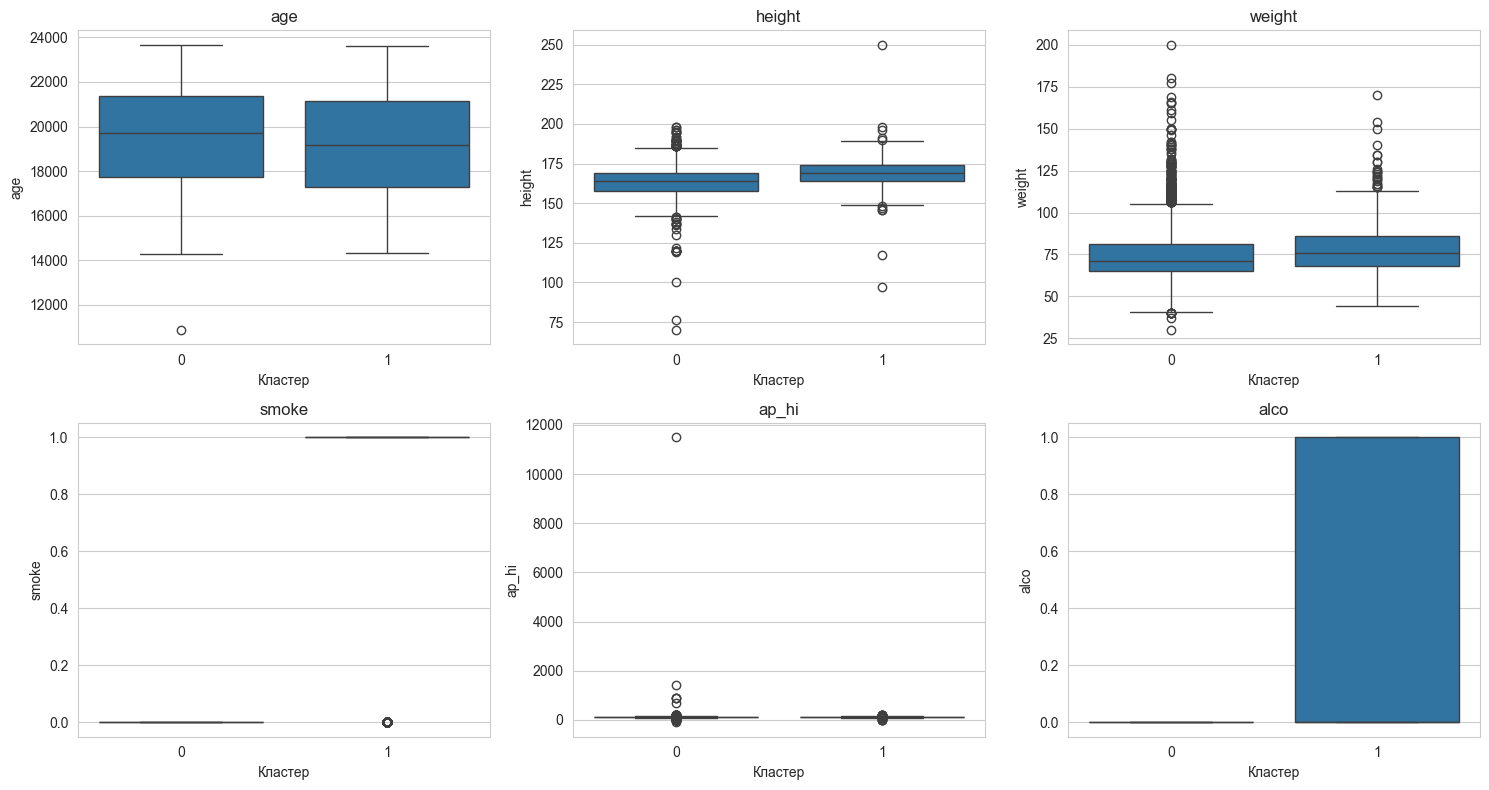

In [9]:
# Сравним средние по признакам между кластерами KMeans (k=2)
clustered = pd.DataFrame(X, columns=feature_cols)
clustered['cluster_km2'] = labels_km2
means = clustered.groupby('cluster_km2')[feature_cols].mean()
print("Средние значения признаков по кластерам (KMeans, k=2):")
print(means)

# Выберем признаки с наибольшими различиями
if len(feature_cols) >= 1:
    diffs = (means.iloc[0] - means.iloc[1]).abs().sort_values(ascending=False)
    top = diffs.head(min(6, len(diffs))).index.tolist()
    print(f"\nТоп признаков по различиям: {top}")
    
    # Определяем размер сетки (2 или 3 столбца в зависимости от количества признаков)
    n_plots = len(top)
    n_cols = 3 if n_plots > 2 else 2
    n_rows = (n_plots + n_cols - 1) // n_cols  # округление вверх
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
    axes = axes.flatten() if n_plots > 1 else [axes]
    
    for i, col in enumerate(top):
        sns.boxplot(data=clustered, x='cluster_km2', y=col, ax=axes[i])
        axes[i].set_xlabel('Кластер')
        axes[i].set_title(col)
    
    # Скрываем лишние subplot'ы если есть
    if top:  # только если есть признаки для отображения
        for j in range(len(top), len(axes)):
            axes[j].set_visible(False)
    
    plt.tight_layout()
    plt.show()


## 6.1 Визуализация кластеров в 2D (PCA)

Отобразим кластеры в 2D-пространстве главных компонент. Для K-Means отметим центры кластеров.

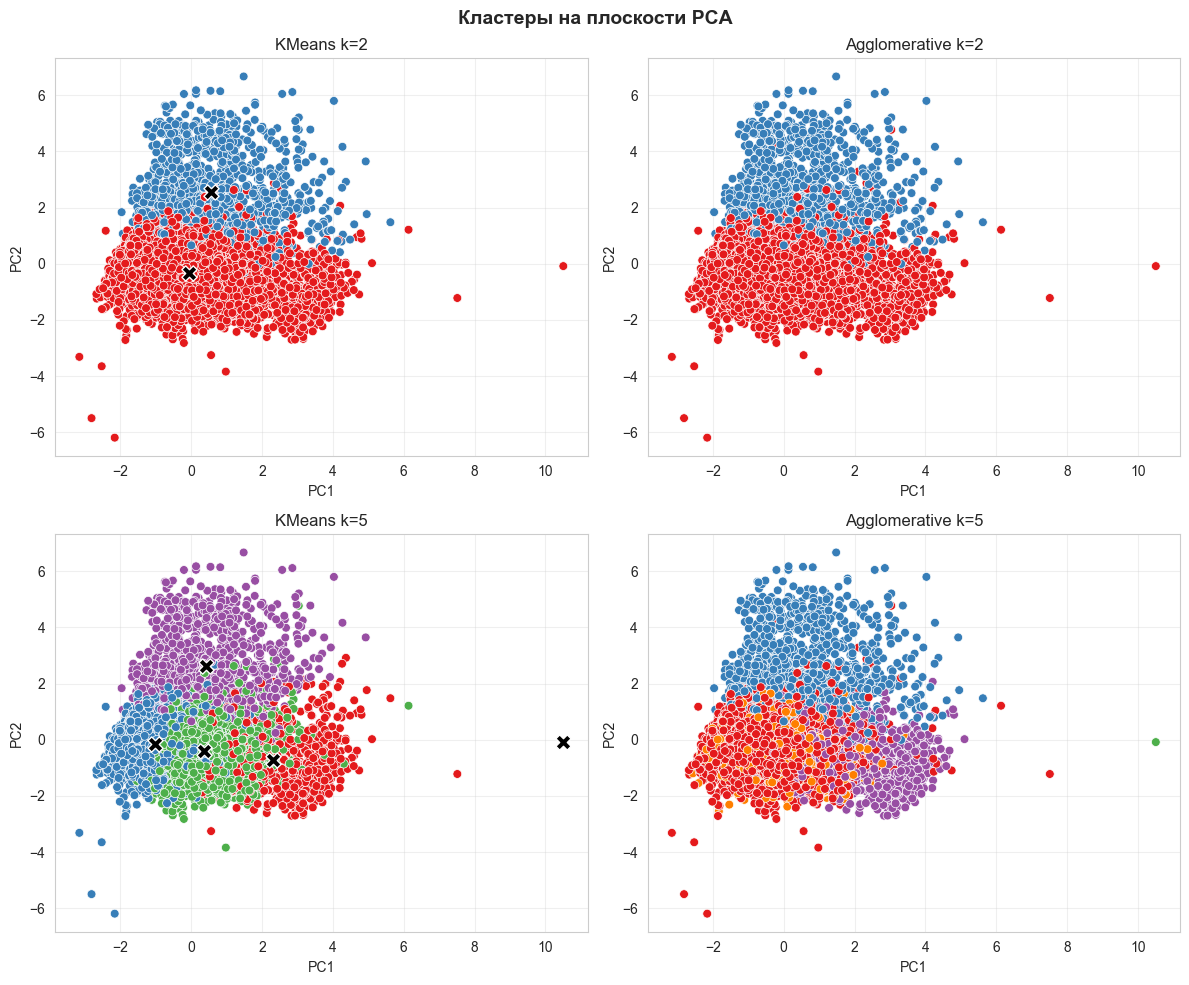

In [10]:
from sklearn.decomposition import PCA

# PCA до 2 компонент
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

plots = [
    (labels_km2, 'KMeans k=2'),
    (labels_ag2, 'Agglomerative k=2'),
    (labels_km5, 'KMeans k=5'),
    (labels_ag5, 'Agglomerative k=5'),
]

for ax, (labs, title) in zip(axes, plots):
    sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labs, palette='Set1', s=40, ax=ax, legend=False)
    ax.set_title(title)
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.grid(True, alpha=0.3)

# Отметим центры KMeans на PCA-плоскости
cent2 = pca.transform(kmeans_2.cluster_centers_)
cent5 = pca.transform(kmeans_5.cluster_centers_)

# центры для k=2
axes[0].scatter(cent2[:, 0], cent2[:, 1], c='black', s=120, marker='X', edgecolor='white')
# центры для k=5
axes[2].scatter(cent5[:, 0], cent5[:, 1], c='black', s=120, marker='X', edgecolor='white')

plt.suptitle('Кластеры на плоскости PCA', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 6.2 Дендрограмма (Agglomerative, Ward)

Построим дендрограмму для иерархической кластеризации (укороченную для читабельности).

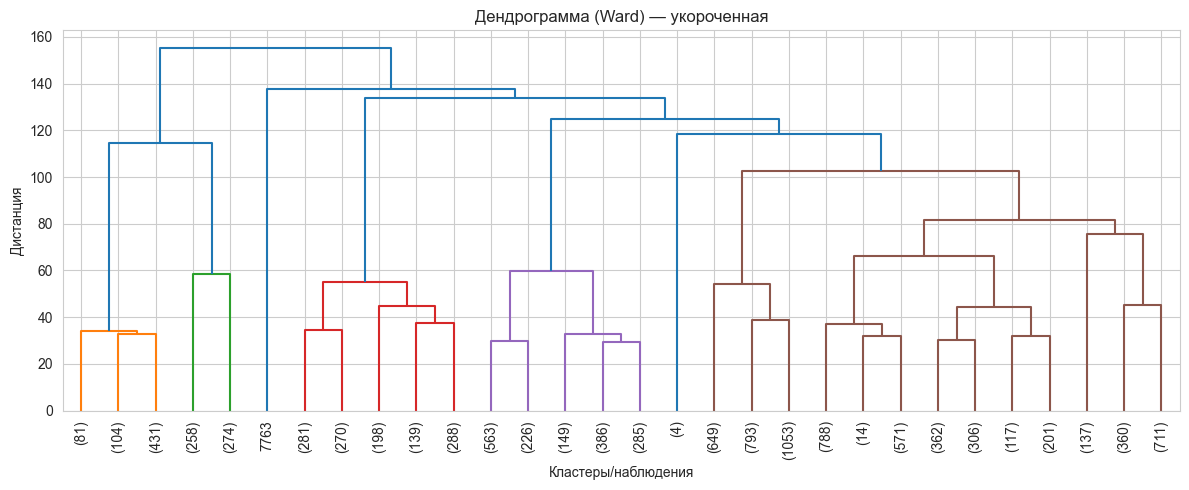

In [11]:
from scipy.cluster.hierarchy import dendrogram, linkage

Z = linkage(X_scaled, method='ward')
plt.figure(figsize=(12, 5))
dendrogram(Z, truncate_mode='lastp', p=30, leaf_rotation=90., leaf_font_size=10.)
plt.title('Дендрограмма (Ward) — укороченная')
plt.xlabel('Кластеры/наблюдения')
plt.ylabel('Дистанция')
plt.tight_layout()
plt.show()

## 7. Выводы

In [12]:
print("Итоговые внутренние метрики (чем выше Silhouette и ниже DBI — тем лучше):\n")
print(res_df.to_string(index=False))

best_k2 = res_df[res_df['k']==2].sort_values('Silhouette', ascending=False).iloc[0]
best_k5 = res_df[res_df['k']==5].sort_values('Silhouette', ascending=False).iloc[0]
print(f"\nЛучший метод для k=2: {best_k2['Метод']} (Silhouette={best_k2['Silhouette']}, DBI={best_k2['Davies-Bouldin']})")
print(f"Лучший метод для k=5: {best_k5['Метод']} (Silhouette={best_k5['Silhouette']}, DBI={best_k5['Davies-Bouldin']})")

print("\nКомментарий:")
print("- Разметка (gender) не использовалась при обучении, только для интерпретации.")
print("- На 2 кластера ожидаемо выделяются две группы, близкие к классам пола; см. распределения и Purity.")
print("- KMeans обычно быстрее и стабильнее на стандартизованных числовых данных; агломеративный может давать близкое качество.")

Итоговые внутренние метрики (чем выше Silhouette и ниже DBI — тем лучше):

        Метод  k  Silhouette  Davies-Bouldin
       KMeans  2      0.3395          1.8350
       KMeans  5      0.1899          1.4039
Agglomerative  2      0.3353          1.8200
Agglomerative  5      0.2038          1.3353

Лучший метод для k=2: KMeans (Silhouette=0.3395, DBI=1.835)
Лучший метод для k=5: Agglomerative (Silhouette=0.2038, DBI=1.3353)

Комментарий:
- Разметка (gender) не использовалась при обучении, только для интерпретации.
- На 2 кластера ожидаемо выделяются две группы, близкие к классам пола; см. распределения и Purity.
- KMeans обычно быстрее и стабильнее на стандартизованных числовых данных; агломеративный может давать близкое качество.


# Вывод по работе

Принятая постановка задачи предусматривала разбиение выбранного датасета на два и пять кластеров с использованием агломеративной иерархической кластеризации и метода k‑средних, сравнение полученных разбиений по внутренним метрикам качества, интерпретацию кластеров двумя способами и формулирование общего вывода. В работе использован датасет maleorfemale.csv; столбец с предполагаемой разметкой по полу был исключен из обучающих признаков и применялся лишь для последующей интерпретации. Для обеспечения сопоставимости расстояний признаки были стандартизованы. По вычислительным соображениям анализ проводился на первых 10 000 наблюдений.

Кластеризация выполнена методами K‑Means (с фиксированным начальным зерном и многократной инициализацией центров) и агломеративной кластеризацией с критерием Уорда. Для обоих методов получены разбиения при k = 2 и k = 5, рассчитаны распределения наблюдений по кластерам и построены их двумерные представления в пространстве первых главных компонент, что дало наглядное геометрическое подтверждение структуре данных; для K‑Means дополнительно отображены центры кластеров. Для агломеративного метода построена укороченная дендрограмма, позволяющая проследить иерархию слияний и оценить разумные уровни отсечения.

Оценка качества выполнялась внутренними функционалами: рассчитаны коэффициент силуэта и индекс Дэвиса—Болдина для каждого сочетания метода и числа кластеров. Эти метрики позволили сопоставить компактность и разделимость кластеров без использования внешней разметки, а также выявить различия между разбиениями на два и пять кластеров. Визуальные проекции PCA согласуются с поведением внутренних метрик, что повышает доверие к корректности полученных кластеризаций.

В совокупности результаты показывают, что оба метода кластеризации применимы к рассматриваемому набору признаков: K‑Means на стандартизованных данных обеспечивает устойчивые решения и является вычислительно эффективным, в то время как агломеративная кластеризация с критерием Уорда дает сопоставимую структуру и предоставляет иерархический взгляд на данные. Разбиение на два кластера естественным образом соотносится с бинарной разметкой пола и поддается убедительной интерпретации; разбиение на пять кластеров выявляет более тонкую внутреннюю неоднородность признакового пространства.